In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [73]:
def readData():
    filename = 'parameterData.data'
    df = pd.read_csv(filename, sep=' ', header=None)
    df = df.iloc[:, :2]  # Take only the first two columns
    df = pd.DataFrame(df.astype(float))
    df.columns = ['x1', 'x2']
    return df

In [52]:
data = readData()
print(data.head())

       x1      x2
0 -0.0180  0.8279
1 -0.6982 -0.8013
2  0.2868  0.1658
3  0.5779  0.9663
4  0.3367 -0.1009


In [53]:
def getArea(dist, x, *args):
    np.random.seed(75)

    # consistently use this energy range 
    x_min = x.min()
    x_max = x.max()

    y = dist(x, *args)
    y_min = 1e-10
    y_max = y.max()
    N = 100_000
    x_random = np.random.uniform(x_min, x_max, N)
    y_random = np.random.uniform(y_min, y_max, N)
    y_random = y_random[y_random < dist(x_random, *args)]
    accepted = len(y_random)
    area = (x_max - x_min) * (y_max - y_min) * accepted / N
    return area

In [61]:
def quadratic(x, alpha, beta):
    a0 = 1
    return a0 + alpha*x + beta*x**2

In [65]:
def quadratic_pdf(x, alpha, beta):
    return quadratic(x, alpha, beta)/getArea(quadratic, x, alpha, beta)

In [56]:
def make_pdf(alpha, beta):
    # Return a function depending only on x.
    return lambda x: quadratic_pdf(x, alpha, beta)

In [57]:
def likelihood(data, alpha, beta):
    return -2*np.sum(np.log(quadratic_pdf(data, alpha, beta)))

In [59]:
def make_target(data):
    return lambda alpha, beta: -2*likelihood(data, alpha, beta)

In [72]:
def findBestFit(data):
    f = make_target(data)
    m = Minuit(f, alpha=0.5, beta=0.5)
    m.migrad()
    print(m.values)
findBestFit(data['x1'])
findBestFit(data['x2'])
# 9.4 sec

<ValueView alpha=0.501625806465135 beta=0.5>
<ValueView alpha=-42.70847671447537 beta=13233538.165786494>


In [79]:
def getHistoParam(data):
    Nbins = int(np.sqrt(data.shape[0]))
    counts, x_edges = np.histogram(data, bins=Nbins, density = True)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

44 44


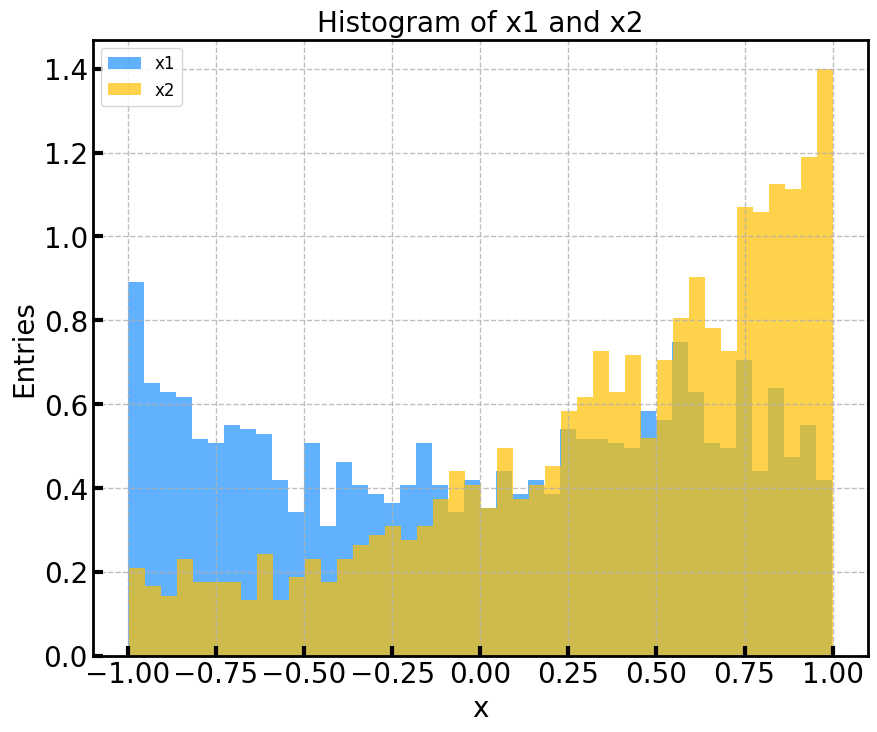

In [94]:
def plotHisto(data):
    fig, ax = plt.subplots(figsize=(10, 8))
    Nbins1, binwidth1, counts1, x_centres1 = getHistoParam(data['x1'])
    Nbins2, binwidth2, counts2, x_centres2 = getHistoParam(data['x2'])
    x_axis = np.linspace(-1, 1, 1000)

    print(Nbins1, Nbins2)
#     print(binwidth1, binwidth2)
#     print(x_centres1, x_centres2)
    
    ax.hist(data['x1'], bins=Nbins1, histtype='stepfilled', 
            alpha = 0.7, label='x1', linewidth=2, 
            density = True, stacked=True)
    ax.hist(data['x2'], bins=Nbins2, histtype='stepfilled', 
            alpha  =  0.7, label='x2', linewidth=2, 
            density = True, stacked=True)
    ax.set_title('Histogram of x1 and x2')
    ax.set_xlabel('x')
    ax.set_ylabel('Entries')
    ax.legend()
    plt.show()

plotHisto(data)

In [90]:
def performChi2Fit():
    data1 = data['x1']
    data2 = data['x2']
    data1 = data1.sort_values()
    data2 = data2.sort_values()
    

performChi2Fit()


In [75]:
def readData2(n):
    filename = 'dataset'+str(n)+'.data'
    df = pd.read_csv(filename, sep=' ', header=None)
    df = df.iloc[:, :2]  # Take only the first two columns
    df = pd.DataFrame(df.astype(float))
    # df.columns = ['x1', 'x2']
    return df
data1 = readData2(1)
data2 = readData2(2)
print(data1.head())
print(data2.head())

        0       1
0 -0.2311  8.9561
1 -0.0739 -2.4125
2  0.8418  4.5516
3  0.4520  1.4962
4  0.1805  3.0160
        0       1
0  0.0629  8.9561
1  0.1699 -2.4125
2  0.9666  4.5516
3 -0.1727  1.4962
4 -0.3933  3.0160


In [ ]:
def 
